In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append("/Volumes/Lab/Users/bhofflic/cell_classification/src")
import istarmap
from tqdm import tqdm
import features_correlations as feat_c
import features_visual as feat_v

sys.path.append("/Volumes/Lab/Users/scooler/classification/")
import cell_display_lib as cdl
import features
import deduplication as dedup
import multiprocessing as mp
from multiprocessing import Pool
import pandas as pd
from file_handling import wrapper


import elephant, warnings
import quantities as pq
from elephant.conversion import BinnedSpikeTrain
from neo import SpikeTrain

import itertools

%load_ext autoreload
%autoreload 2

In [2]:
classification_types = ['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget', 
                        'SBC', 'ON smooth', 'OFF smooth', 
                        'ON A1', 'OFF A1', 'OFF BT', 'OFF blobby amacrine', 'OFF RB']

def get_merged_unit(unit_table, unit_id):
    run = unit_id[1]
    merged_units = unit_table.query("merged == True and run_id == @run")
    unit = unit_table.loc[unit_id]
    cell_id = unit['cell_id']
    if cell_id in list(merged_units['cell_id']):
        return merged_units.query("cell_id == @cell_id").index[0]
    else:
        return unit_id

In [3]:
cch_data = pd.read_pickle('/Volumes/Scratch/Users/bhofflic/correlations/average_cchs.pkl')

In [4]:
piece_id = "2015-09-23-7"

ct = cdl.CellTable()
print(piece_id)
ct.file_load_pieces(f'/Volumes/Scratch/Users/bhofflic/celltable_runs/', [piece_id])

~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable
2015-09-23-7
~ Loading 1 pieces from /Volumes/Scratch/Users/bhofflic/celltable_runs/: /Volumes/Scratch/Users/bhofflic/celltable_runs/
*** timer  started
Loading piece 2015-09-23-7
~ Successfully loaded piece 2015-09-23-7
*** elapsed 272s of 272s = 4.5m elapsed, of 4.5m estimated (1/1) (0.0 / sec)
~ Processing labels (replace nan, update label encoder and unique names)
Copying cell labels to units
combined mode
~ Done loading, time to analyze.


In [5]:
# %%
# anchor_types = ['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget']
anchor_types = classification_types
cell_cchs = {'piece_id':[], 'run_id':[], 'unit_id':[], 'cell_type': []}
cell_cchs.update({anchor_type: [] for anchor_type in anchor_types})
classification_runs = cch_data.query("piece_id == @piece_id").run_id.unique()

for run_id in classification_runs:
    overlaps = ct.dataset_table.loc[(piece_id, run_id), 'rf_overlaps'].a
    cch_1ms = ct.dataset_table.loc[(piece_id, run_id), 'cch_1ms'].a
    cch_10ms = ct.dataset_table.loc[(piece_id, run_id), 'cch_10ms'].a
    cch_ids = ct.dataset_table.loc[(piece_id, run_id), 'cch_ids'].a
    indices = {cell_type: set() for cell_type in classification_types}
    
    for cell_type in classification_types:
        units = ct.unit_table.query(f"piece_id == @piece_id and run_id == @run_id and label_manual_text == '{cell_type}' and valid == True")
        for unit in units.index:
            nd_unit = get_merged_unit(ct.unit_table, unit)
            if ct.unit_table.loc[nd_unit].valid == False:
                # print(f"Invalid unit {nd_unit}")
                continue
            indices[cell_type].add(np.where(cch_ids == nd_unit)[0][0])
    indices = {cell_type: list(indices[cell_type]) for cell_type in classification_types}
    
    for cch_idx, uid in enumerate(ct.dataset_table.loc[(piece_id, run_id), 'cch_ids'].a):
        valid = False
        cell_cchs['piece_id'].append(piece_id)
        cell_cchs['run_id'].append(run_id)
        cell_cchs['unit_id'].append(uid[2])
        cell_cchs['cell_type'].append(ct.unit_table.loc[uid].label_manual_text)
        for anchor_type in anchor_types:
            anchor_indices = indices[anchor_type]
            if len(anchor_indices) == 0:
                cell_cchs[anchor_type].append(None)
                continue
            anchor_overlap = overlaps[cch_idx, anchor_indices]
            valid_anchor_overlap = np.where(np.logical_and((anchor_overlap < 1),(anchor_overlap > 0.1)))[0]
            if len(valid_anchor_overlap) == 0:
                cell_cchs[anchor_type].append(None)
                continue
            valid_anchor_indices = np.array(anchor_indices)[valid_anchor_overlap]
            cchs_1ms = cch_1ms[cch_idx, valid_anchor_indices, :]
            cchs_1ms -= np.mean(np.concatenate((cchs_1ms[:,:10],cchs_1ms[:,-10:]), axis=1))
            cchs_10ms = cch_10ms[cch_idx, valid_anchor_indices, :]
            cchs_10ms -= np.mean(np.concatenate((cchs_10ms[:,:10],cchs_10ms[:,-10:]), axis=1))

            weights = 1/overlaps[cch_idx, valid_anchor_indices]
            avg_cell_anchor_cch_1ms = np.average(cchs_1ms/np.max(np.abs(cchs_1ms), axis=1)[:,None], axis=0, weights=weights)
            avg_cell_anchor_cch_10ms = np.average(cchs_10ms/np.max(np.abs(cchs_10ms), axis=1)[:,None], axis=0, weights=weights)
            avg_cell_anchor_cch = np.array([avg_cell_anchor_cch_1ms, avg_cell_anchor_cch_10ms])
            cell_cchs[anchor_type].append(wrapper(avg_cell_anchor_cch))
            valid = True
        if not valid:
            cell_cchs['piece_id'].pop()
            cell_cchs['run_id'].pop()
            cell_cchs['unit_id'].pop()
            cell_cchs['cell_type'].pop()
            for anchor_type in anchor_types:
                cell_cchs[anchor_type].pop()

In [8]:
new_training_data = pd.DataFrame(cell_cchs, index=[cell_cchs['piece_id'], cell_cchs['run_id'], cell_cchs['unit_id']])

In [9]:
new_training_data

piece_id run_id  unit_id    cell_type ON parasol  \
2015-09-23-7 037 1      2015-09-23-7    037        1   OFF midget     a2x223   
                 2      2015-09-23-7    037        2  OFF parasol     a2x223   
                 3      2015-09-23-7    037        3   OFF midget     a2x223   
                 4      2015-09-23-7    037        4  OFF parasol     a2x223   
                 5      2015-09-23-7    037        5    ON midget     a2x223   
...                              ...    ...      ...          ...        ...   
             007 91240  2015-09-23-7    007    91240   ON parasol       None   
                 91242  2015-09-23-7    007    91242  OFF parasol     a2x223   
                 91243  2015-09-23-7    007    91243   ON parasol       None   
                 91244  2015-09-23-7    007    91244   ON parasol     a2x223   
                 91245  2015-09-23-7    007    91245   ON parasol       None   

                       OFF parasol ON midget OFF midget     SBC ON smooth  \
2015-09-23-7 037 1          a2x223    a2x223     a2x223  a2x223      None   
                 2          a2x223    a2x223     a2x223  a2x223      None   
                 3          a2x223    a2x223     a2x223  a2x223      None   
                 4          a2x223    a2x223     a2x223  a2x223      None   
                 5          a2x223    a2x223     a2x223    None      None   
...                            ...       ...        ...     ...       ...   
             007 91240      a2x223    a2x223     a2x223  a2x223      None   
                 91242        None    a2x223     a2x223    None      None   
                 91243      a2x223    a2x223     a2x223  a2x223      None   
                 91244      a2x223    a2x223     a2x223  a2x223      None   
                 91245      a2x223    a2x223     a2x223    None      None   

                       OFF smooth ON A1 OFF A1 OFF BT OFF blobby amacrine  \
2015-09-23-7 037 1           None  None   None   None                None   
                 2         a2x223  None   None   None                None   
                 3         a2x223  None   None   None                None   
                 4         a2x223  None   None   None                None   
                 5         a2x223  None   None   None                None   
...                           ...   ...    ...    ...                 ...   
             007 91240     a2x223  None   None   None                None   
                 91242       None  None   None   None                None   
                 91243     a2x223  None   None   None                None   
                 91244       None  None   None   None                None   
                 91245       None  None   None   None                None   

                       OFF RB  
2015-09-23-7 037 1       None  
                 2       None  
                 3       None  
                 4       None  
                 5       None  
...                       ...  
             007 91240   None  
                 91242   None  
                 91243   None  
                 91244   None  
                 91245   None  

[6161 rows x 16 columns]

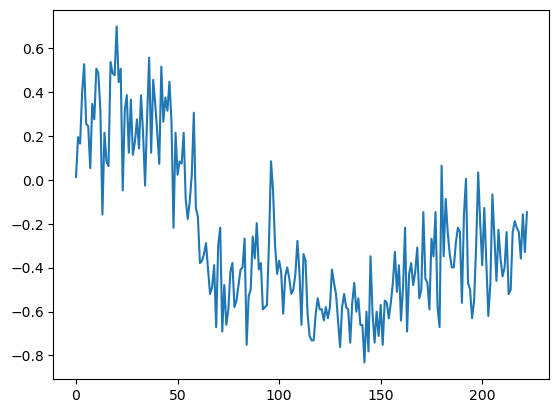

In [45]:
plt.plot(new_training_data.query("cell_type == 'ON smooth'")['OFF parasol'].iloc[28].a[0,:])

In [48]:
all_cchs = [new_training_data.query("cell_type == 'ON smooth'")['OFF midget'].iloc[i].a[0,:] for i in range(len(new_training_data.query("cell_type == 'ON smooth'"))) if new_training_data.query("cell_type == 'ON smooth'")['OFF midget'].iloc[i] is not None]

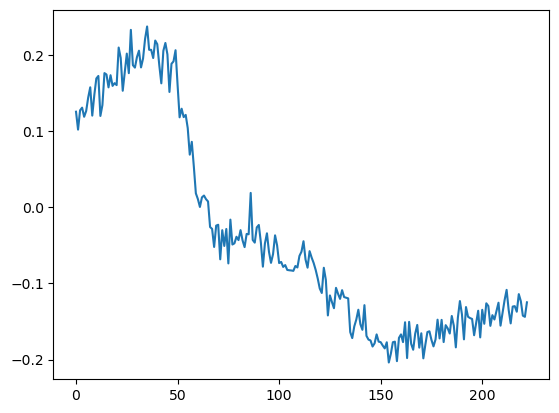

In [49]:
avg = np.mean(all_cchs, axis=0)
plt.plot(avg)

In [17]:
training_data = pd.read_pickle('/Volumes/Scratch/Users/bhofflic/correlations/training_data.pkl')
training_data.update(new_training_data)
training_data

piece_id run_id  unit_id     cell_type ON parasol  \
2015-09-23-7 037 1      2015-09-23-7    037      1.0    OFF midget     a2x223   
                 2      2015-09-23-7    037      2.0   OFF parasol     a2x223   
                 3      2015-09-23-7    037      3.0    OFF midget     a2x223   
                 4      2015-09-23-7    037      4.0   OFF parasol     a2x223   
                 5      2015-09-23-7    037      5.0     ON midget     a2x223   
...                              ...    ...      ...           ...        ...   
2018-08-07-9 000 91562  2018-08-07-9    000  91562.0     ON midget     a2x223   
                 91563  2018-08-07-9    000  91563.0    ON parasol     a2x223   
                 91564  2018-08-07-9    000  91564.0    OFF midget     a2x223   
                 91565  2018-08-07-9    000  91565.0        OFF BT     a2x223   
                 91566  2018-08-07-9    000  91566.0  contaminated       None   

                       OFF parasol ON midget OFF midget     SBC ON smooth  \
2015-09-23-7 037 1          a2x223    a2x223     a2x223  a2x223      None   
                 2          a2x223    a2x223     a2x223  a2x223      None   
                 3          a2x223    a2x223     a2x223  a2x223      None   
                 4          a2x223    a2x223     a2x223  a2x223      None   
                 5          a2x223    a2x223     a2x223    None      None   
...                            ...       ...        ...     ...       ...   
2018-08-07-9 000 91562      a2x223      None     a2x223  a2x223      None   
                 91563      a2x223    a2x223       None    None      None   
                 91564      a2x223    a2x223       None  a2x223      None   
                 91565      a2x223    a2x223     a2x223    None    a2x223   
                 91566      a2x223    a2x223     a2x223    None      None   

                       OFF smooth   ON A1  OFF A1 OFF BT OFF blobby amacrine  \
2015-09-23-7 037 1           None    None    None   None                None   
                 2         a2x223    None    None   None                None   
                 3         a2x223    None    None   None                None   
                 4         a2x223    None    None   None                None   
                 5         a2x223    None    None   None                None   
...                           ...     ...     ...    ...                 ...   
2018-08-07-9 000 91562     a2x223    None  a2x223   None                None   
                 91563       None    None    None   None                None   
                 91564     a2x223  a2x223    None   None                None   
                 91565       None    None    None   None                None   
                 91566       None  a2x223    None   None                None   

                       OFF RB  
2015-09-23-7 037 1       None  
                 2       None  
                 3       None  
                 4       None  
                 5       None  
...                       ...  
2018-08-07-9 000 91562   None  
                 91563   None  
                 91564   None  
                 91565   None  
                 91566   None  

[39591 rows x 16 columns]

In [18]:
training_data.to_pickle(f'/Volumes/Scratch/Users/bhofflic/correlations/training_data.pkl')